<a href="https://colab.research.google.com/github/mumerabbasi/NLP/blob/main/Multi_Class_Classification_with_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing keras from tensor flow to use Google Colab's TPU (To accelerate training)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Embedding, SpatialDropout1D, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Importing libraries required for cleaning text
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# Importing for tokenizing our reviews
from keras.preprocessing.text import Tokenizer

# Importing for Padding our text to make all reviews have equal length
from keras.preprocessing.sequence import pad_sequences

In [2]:
# To import data file from your google drive.
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Multi Class Review Classification/YELP_Reviews_Data.csv'  # gdrive/My Drive/Folder Name/File Name.csv

Mounted at /content/gdrive


In [3]:
# Reading data from file into a Pandas DataFrame
df =  pd.read_csv(path, sep='<')
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,stars_str,txt_len,sent_label,sent_score
0,i1buEuYYo9CvosniQ64DJg,K0HrAbJrNfceo3tk1VOWiw,yn76xXVpL6Ejt47HqJ0YiQ,1,0,1,0,I see the owner finally decided to reply to so...,2019-05-23 21:04:21,1,2958,-1,0.999629
1,oyqPnwGQaOL9-n8Z1YmcDA,fMX9IsFT5awrkNaZJnEv3A,n85oc0lNQhEDomqhljmZqg,1,1,0,0,Just gross. I had the 'crispy' chicken sandwic...,2017-11-19 21:28:29,1,352,-1,0.999609
2,0Bfai921X7GUt4U2xLcYSQ,jMqD6Sl_3Msi53aVA0KTRg,AvXqLbcGCxdIEF_qZTY0Kw,1,1,0,0,I saw this restaurant on TV. So it was on my l...,2014-07-15 14:40:29,1,640,-1,0.999689
3,AaZwkwIMO0vw-sQvp1S2IA,0FZW665jtUeVa_Nej6h_gA,tMnK-Pip_N_XiGo4wPjegQ,1,2,0,0,Ordered $45 worth of food through Grubhub- two...,2016-03-01 00:41:09,1,683,-1,0.999553
4,0ZuDXldIHDj-o-hew4IjCQ,Bn6lNYr5fSgl1WmeNenGvA,JX-7i6KGbqejH1JBBzv5JQ,1,1,0,0,My girlfriend and went to the AMC Loews theate...,2014-10-05 13:21:44,1,960,-1,0.999554


In [4]:
# Dropping unecessary columns.
df = df[['text', 'stars']]
df.describe(include = 'all')

,text,stars
count,250000,250000.000000
unique,249931,NaN
top,The pharmacists are too strict on picking up c...,NaN
freq,2,NaN
mean,NaN,3.000000
std,NaN,1.414216
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,3.000000
75%,NaN,4.000000


In [5]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Function for cleaning HTML
def clean_Html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

# Function for cleaning Uppercase letters
def keep_Alpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

# Function for stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# Applying these functions to our DataFrame
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(clean_Html)
df['text'] = df['text'].apply(clean_Punc)
df['text'] = df['text'].apply(keep_Alpha)
df['text'] = df['text'].apply(stemming)

df.head()

,text,stars
0,i see the owner final decid to repli to someon...,1
1,just gross i had the crispi chicken sandwich i...,1
2,i saw this restaur on tv so it was on my list ...,1
3,order worth of food through grubhub two dinner...,1
4,my girlfriend and went to the amc loew theater...,1


In [6]:
# Performing Tokenization
max_num_words = 10000 # Max number of the most frequents words to be used
max_len = 1000 # Max number of words in each review
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)

In [13]:
# Padding reviews to make them have equal length
x = tokenizer.texts_to_sequences(df['text'].values)
x = pad_sequences(x, maxlen=max_len)

In [14]:
# Performing OneHot Encoding of Stars
y = pd.get_dummies(data=df[['stars']], columns=['stars']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (250000, 5)


In [15]:
# Splitting dataset into Train and Test datasets in 70:30
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(175000, 1000) (175000, 5)
(75000, 1000) (75000, 5)


In [17]:
# configuring Google Colabs's TPU for model training
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.104.189.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.189.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [23]:
# Enabling Google Colabs's TPU
with tpu_strategy.scope():
  # Building a GRU Model
  model=Sequential()
  model.add(Embedding(max_num_words, embedding_dim, input_length=max_len, trainable=False))
  model.add(Bidirectional(GRU(32)))
  model.add(Dense(16, activation="relu"))
  model.add(Dense(5, activation="softmax"))
  model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
 
  epochs = 50
  batch_size = 64
  # Training a GRU model on Colab's TPU
  GRU_Model = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/50
2461/2461 [==============================] - 256s 101ms/step - loss: 1.4394 - accuracy: 0.3462 - val_loss: 1.3162 - val_accuracy: 0.4232
Epoch 2/50
2461/2461 [==============================] - 244s 99ms/step - loss: 1.2559 - accuracy: 0.4553 - val_loss: 1.1961 - val_accuracy: 0.4769
Epoch 3/50
2461/2461 [==============================] - 244s 99ms/step - loss: 1.1621 - accuracy: 0.4949 - val_loss: 1.1420 - val_accuracy: 0.5013
Epoch 4/50
2461/2461 [==============================] - 243s 99ms/step - loss: 1.1049 - accuracy: 0.5183 - val_loss: 1.0857 - val_accuracy: 0.5246
Epoch 5/50
2461/2461 [==============================] - 243s 99ms/step - loss: 1.0687 - accuracy: 0.5344 - val_loss: 1.0630 - val_accuracy: 0.5386
Epoch 6/50
2461/2461 [==============================] - 244s 99ms/step - loss: 1.0424 - accuracy: 0.5449 - val_loss: 1.0388 - val_accuracy: 0.5431
Epoch 7/50
2461/2461 [==============================] - 244s 99ms/step - loss: 1.0212 - accuracy: 0.5532 - val_loss: 

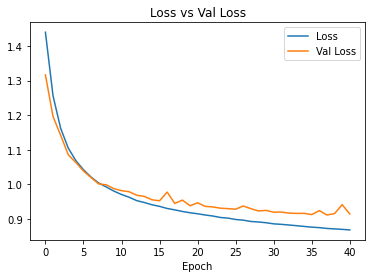

In [24]:
plt.plot(GRU_Model.history['loss'])
plt.plot(GRU_Model.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.show()

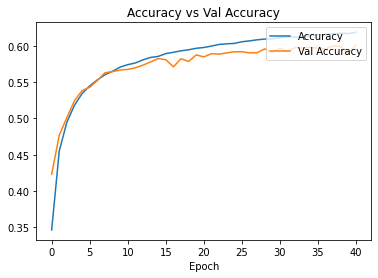

In [25]:
plt.plot(GRU_Model.history['accuracy'])
plt.plot(GRU_Model.history['val_accuracy'])
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper right')
plt.show()

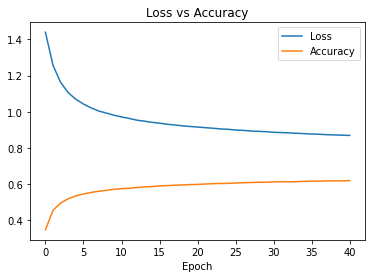

In [45]:
plt.plot(GRU_Model.history['loss'])
plt.plot(GRU_Model.history['accuracy'])
plt.title('Loss vs Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

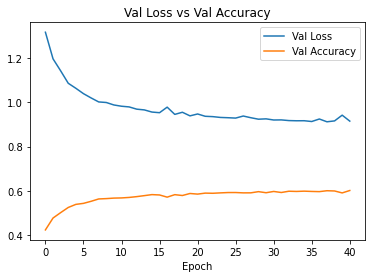

In [46]:
plt.plot(GRU_Model.history['val_loss'])
plt.plot(GRU_Model.history['val_accuracy'])
plt.title('Val Loss vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Loss', 'Val Accuracy'], loc='upper right')
plt.show()

In [26]:
# Evaluting model on Test Set
test = model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test[0], test[1]))

2344/2344 [==============================] - 104s 44ms/step - loss: 0.9095 - accuracy: 0.6040
For Test Set
  Loss: 0.910
  Accuracy: 0.604


In [43]:
# Saving Trained Model in Google Drive 
model_path = 'gdrive/My Drive/Colab Notebooks/Multi Class Review Classification/Classification_Review_Stars_60Acc_41Epochs.h5'
model.save(model_path)

In [44]:
# Loading and Verifiying the Trained Model
loaded_model = tf.keras.models.load_model(model_path)
test1 = loaded_model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test1[0], test1[1]))

2344/2344 [==============================] - 163s 69ms/step - loss: 0.9092 - accuracy: 0.6042
For Test Set
  Loss: 0.909
  Accuracy: 0.604


Loaded model verified Successfully.